# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [1]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

In [2]:
import numpy as np
import warnings
import seaborn as sns

# metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
# processor
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
from sklearn.pipeline import make_pipeline

# machine learning
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')

In [3]:
print("train shape:"), print(train.shape), print("---"*20)
print("test shape:"), print(test.shape), print("---"*20)
print("train columns:"), print(train.columns), print("---"*20)
print("test columns:"), print(test.columns), print("---"*20)
print("train dtypes.sort_values(ascending=False):"), print(train.dtypes.sort_values(ascending=False)), print("---"*20)
print("test dtypes.sort_values(ascending=False):"), print(test.dtypes.sort_values(ascending=False)), print("---"*20)
print("train isna().sum().sort_values(ascending=False):"), print(train.isna().sum().sort_values(ascending=False)), print("---"*20)
print("test isna().sum().sort_values(ascending=False):"), print(test.isna().sum().sort_values(ascending=False)), print("---"*20)

train shape:
(51916, 17)
------------------------------------------------------------
test shape:
(17306, 17)
------------------------------------------------------------
train columns:
Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')
------------------------------------------------------------
test columns:
Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')
------------------------------------------------------------
train dtypes.sort_values(ascending=False):
State               object
DBA Name            object
Violations          object
Inspection Type     object
Ins

(None, None, None)

In [4]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [5]:
test.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,114835,7 - ELEVEN,7 - ELEVEN,46907.0,Grocery Store,Risk 2 (Medium),600 S DEARBORN,CHICAGO,IL,60605.0,2011-03-22T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874481,-87.629357,"{'longitude': '-87.62935653990546', 'latitude'...",0
1,1575555,TAQUERIA LOS GALLOS INC,TAQUERIA LOS GALLOS,1044860.0,Restaurant,Risk 1 (High),4209-4211 W 26TH ST,CHICAGO,IL,60623.0,2015-09-15T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.844070,-87.729807,"{'longitude': '-87.72980747367433', 'latitude'...",0
2,671061,TROTTER'S TO GO,TROTTER'S TO GO,1092634.0,Restaurant,Risk 1 (High),1337 W FULLERTON AVE,CHICAGO,IL,60614.0,2012-03-02T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.925128,-87.662041,"{'longitude': '-87.66204067083224', 'latitude'...",0
3,1965844,BIG G'S PIZZA,BIG G'S PIZZA,2334691.0,Restaurant,Risk 1 (High),1132 W TAYLOR ST,CHICAGO,IL,60607.0,2016-10-04T00:00:00,Canvass Re-Inspection,"14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42...",41.869546,-87.655501,"{'longitude': '-87.65550098867566', 'latitude'...",1
4,1751669,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,3491970.0,School,Risk 2 (Medium),1021 E 83RD,CHICAGO,IL,60619.0,2016-04-08T00:00:00,Canvass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.743933,-87.599291,"{'longitude': '-87.59929083361996', 'latitude'...",1


In [7]:
train.corr()
# 'Fail' column have the information that we are try to predict and can cause leakage if included.

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
Inspection ID,1.000000,0.194781,0.000944,0.053912,-0.008544,0.004624
License #,0.194781,1.000000,-0.016444,0.006098,0.035326,0.043235
Zip,0.000944,-0.016444,1.000000,0.185379,-0.399629,0.014190
Latitude,0.053912,0.006098,0.185379,1.000000,-0.430789,-0.014143
Longitude,-0.008544,0.035326,-0.399629,-0.430789,1.000000,0.015747
Fail,0.004624,0.043235,0.014190,-0.014143,0.015747,1.000000


In [6]:
for i in train.columns:
    print(i,train[i].value_counts().shape)

Inspection ID (51916,)
DBA Name (17049,)
AKA Name (16350,)
License # (21421,)
Facility Type (329,)
Risk (3,)
Address (13954,)
City (39,)
State (1,)
Zip (86,)
Inspection Date (2257,)
Inspection Type (51,)
Violations (42164,)
Latitude (13410,)
Longitude (13410,)
Location (13410,)
Fail (2,)


In [20]:
def wrangle(X):
    X = X.copy()
    
    # Drop columns
    X = X.drop(columns = ['Inspection ID','DBA Name', 'AKA Name', 'Address', 'State', 'City',
                          'Inspection Date', 'Location', 'Zip']) 
    X['Violations'] = X.Violations.isna()
    X = X.dropna()
    return X
    
train = wrangle(train)
test = wrangle(test)

print(train.shape, test.shape)
print("-"*100)
print(train.isnull().sum())
print("-"*100)
train.info()

(51483, 8) (17153, 8)
----------------------------------------------------------------------------------------------------
License #          0
Facility Type      0
Risk               0
Inspection Type    0
Violations         0
Latitude           0
Longitude          0
Fail               0
dtype: int64
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51483 entries, 0 to 51482
Data columns (total 8 columns):
License #          51483 non-null float64
Facility Type      51483 non-null object
Risk               51483 non-null object
Inspection Type    51483 non-null object
Violations         51483 non-null bool
Latitude           51483 non-null float64
Longitude          51483 non-null float64
Fail               51483 non-null int64
dtypes: bool(1), float64(3), int64(1), object(3)
memory usage: 2.8+ MB


In [9]:
X_train = train.drop('Fail', axis=1)
X_test = test.drop('Fail', axis=1)
y_train = train['Fail']
y_test = test['Fail']

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
clf = XGBClassifier()

cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ....................... , score=0.7159554535656596, total=   3.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] ....................... , score=0.7121163690592773, total=   2.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV] ....................... , score=0.7275401234936392, total=   3.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s


[CV] ....................... , score=0.7300046392490339, total=   3.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.6s remaining:    0.0s


[CV] ....................... , score=0.7255210518263342, total=   3.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.7s finished


array([0.71595545, 0.71211637, 0.72754012, 0.73000464, 0.72552105])

Violations         0.406530
Inspection Type    0.260824
License #          0.101653
Risk               0.066925
Latitude           0.061627
Facility Type      0.056464
Longitude          0.045977
dtype: float32
----------------------------------------------------------------------------------------------------


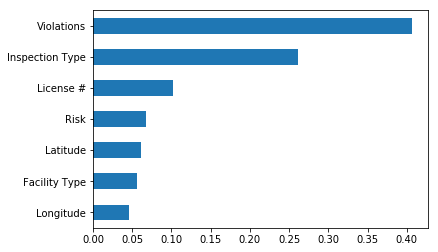

In [10]:
clf.fit(X_train, y_train)
print(pd.Series(clf.feature_importances_, X_train.columns).sort_values(ascending=False))
print("-"*100)
pd.Series(clf.feature_importances_, X_train.columns).sort_values(ascending=True).plot.barh();

In [21]:
import eli5
from eli5.sklearn import PermutationImportance

encoder = ce.OrdinalEncoder()
X_train_transformed = encoder.fit_transform(X_train)

model = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    min_samples_leaf=0.005, 
    n_jobs=-1)

model.fit(X_train_transformed, y_train)
permuter = PermutationImportance(model, scoring='roc_auc', n_iter=1, cv='prefit')
permuter.fit(X_train_transformed, y_train)
eli5.show_weights(permuter, top=None, feature_names=X_train_transformed.columns.tolist())

Weight,Feature
0.1292 ± 0.0000,Inspection Type
0.0732 ± 0.0000,Violations
0.0281 ± 0.0000,License #
0.0221 ± 0.0000,Latitude
0.0202 ± 0.0000,Longitude
0.0083 ± 0.0000,Facility Type
0.0065 ± 0.0000,Risk


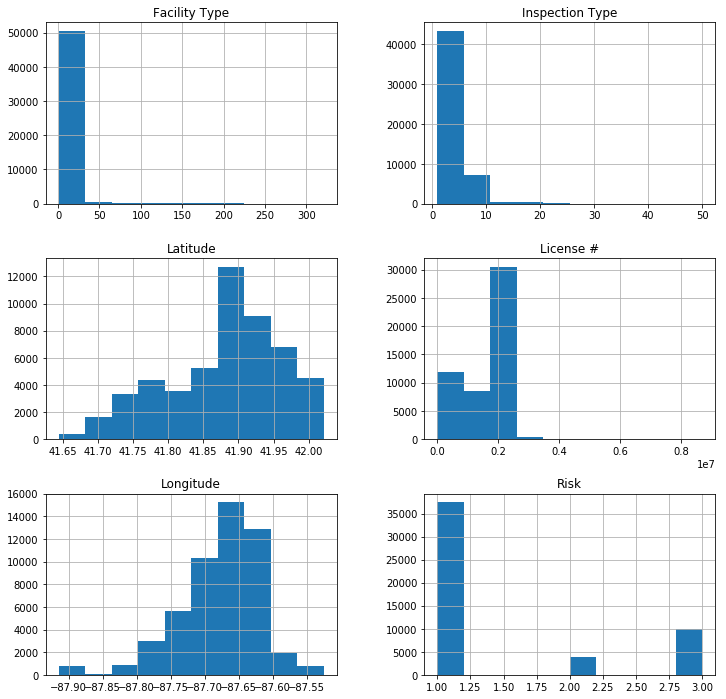

In [26]:
X_train_transformed.drop(columns=['Violations']).hist(figsize=(12,12));